In [1]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### References

The referenced chapters, formulae and problems are from the book [Computational Physics, by Jos Thijssen](https://www.cambridge.org/core/books/computational-physics/BEE73B0139D4A9993193B57CDC62096E#fndtn-information).

What follows is copied directly from hatree-fock.ipynb, check that one for details. The interesting new part is after this portion. If you already looked over the Hartree-Fock, you can skip it.

In [2]:
# 3.26, 4.16
def Gaussian(alpha, r):
    return m.exp(-alpha*r*r)

In [3]:
alpha=(13.00773, 1.962079, 0.444529, 0.1219492)

In [4]:
# see 4.114 and 4.116
def F0(t):
    if t==0:
        return 1.
    p = m.sqrt(t)
    a = 1. / p
    return a * m.sqrt(m.pi) / 2. * m.erf(p)

In [5]:
# 4.98
def Rp(alpha, beta, Ra, Rb):
    return (alpha*Ra + beta*Rb) / (alpha + beta)

In [6]:
# 4.100
def OverlapTwoCenters(alpha, beta, Ra, Rb):
    difR = Ra - Rb
    len2 = difR.dot(difR)
    aplusb = alpha + beta
    ab = alpha * beta / aplusb
    return m.pow(m.pi / aplusb, 3./2.) * m.exp(-ab * len2)

In [7]:
# 4.103
def KineticTwoCenters(alpha, beta, Ra, Rb):
    difR = Ra - Rb
    len2 = difR.dot(difR)
    aplusb = alpha + beta
    ab = alpha * beta / aplusb
    O = m.pow(m.pi/aplusb, 3./2.) * m.exp(-ab * len2) # it's actually the overlap, check the OverlapTwoCenters
    return ab * (3. - 2. * ab * len2) * O #this can be optimized with already computed overlap, see above

In [8]:
# 4.115
def Nuclear(alpha, beta, Ra, Rb, Rc, Z = 1.):
    aplusb = alpha + beta
    ab = alpha * beta / aplusb
    difR = Ra - Rb
    len2 = difR.dot(difR)
    difRc = Rp(alpha, beta, Ra, Rb) - Rc
    len2c = difRc.dot(difRc)
    K = m.exp(-ab*len2)
    return -2. * m.pi * Z / aplusb * K * F0(aplusb*len2c)

In [9]:
# 4.123
def TwoElectronTwoCenter(alpha, beta, gamma, delta, Ra, Rb, Rc, Rd):
    RP = Rp(alpha, gamma, Ra, Rc)
    RQ = Rp(beta, delta, Rb, Rd)
    alphaplusgamma = alpha + gamma
    betaplusdelta = beta + delta
    Rac = Ra - Rc
    Rbd = Rb - Rd
    Rpq = RP - RQ
    Racl2 = Rac.dot(Rac)
    Rbdl2 = Rbd.dot(Rbd)
    Rpql2 = Rpq.dot(Rpq)
    return 2. * m.pow(m.pi, 5./2.) / (alphaplusgamma * betaplusdelta * m.sqrt(alphaplusgamma+betaplusdelta)) * \
           m.exp(-alpha*gamma/alphaplusgamma*Racl2 - beta*delta/betaplusdelta*Rbdl2) *\
           F0(alphaplusgamma*betaplusdelta / (alphaplusgamma+betaplusdelta) * Rpql2)

In [10]:
basisSize = 4 # for each atom

X = 1. # distance between atoms

R0 = np.array([0, 0, 0])
R1 = np.array([X, 0, 0])

In [11]:
H = np.zeros((basisSize * 2, basisSize * 2))
O = np.zeros((basisSize * 2, basisSize * 2))

for i in range(basisSize):
    a = alpha[i]
    for j in range(basisSize):
        b = alpha[j]
        
        O[i, j] = OverlapTwoCenters(a, b, R0, R0)
        O[i, 4 + j] = OverlapTwoCenters(a, b, R0, R1)
        O[4 + i, j] = O[i, 4 + j]
        O[4 + i, 4 + j] = O[i, j]   
        
        H[i, j] = KineticTwoCenters(a, b, R0, R0) + Nuclear(a, b, R0, R0, R0) + Nuclear(a, b, R0, R0, R1)
        H[i, 4 + j] = KineticTwoCenters(a, b, R0, R1) + Nuclear(a, b, R0, R1, R0) + Nuclear(a, b, R0, R1, R1)
        H[4 + i, j] =  H[i, 4 + j]
        H[4 + i, 4 + j] = H[i, j]

In [12]:
Q = np.zeros((basisSize*2, basisSize*2, basisSize*2, basisSize*2))

for i in range(basisSize):
    a = alpha[i]
    basisSizei = basisSize + i
    for j in range(basisSize):
        b = alpha[j]
        basisSizej = basisSize + j
        for k in range(basisSize):
            c = alpha[k]
            basisSizek = basisSize + k
            for l in range(basisSize):
                basisSizel = basisSize + l
                d = alpha[l]        
                
                Q[i, j, k, l]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R0, R0)
                Q[i, j, k, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R0, R1)
                Q[i, j, basisSizek, l]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R1, R0)
                Q[i, j, basisSizek, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R1, R1)
                Q[i, basisSizej, k, l]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R0, R0)
                Q[i, basisSizej, k, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R0, R1)
                Q[i, basisSizej, basisSizek, l]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R1, R0)
                Q[i, basisSizej, basisSizek, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R1, R1)
                Q[basisSizei, j, k, l]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R0, R0)
                Q[basisSizei, j, k, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R0, R1)
                Q[basisSizei, j, basisSizek, l]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R1, R0)
                Q[basisSizei, j, basisSizek, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R1, R1)
                Q[basisSizei, basisSizej, k, l]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R0, R0)
                Q[basisSizei, basisSizej, k, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R0, R1)
                Q[basisSizei, basisSizej, basisSizek, l]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R1, R0)
                Q[basisSizei, basisSizej, basisSizek, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R1, R1)  

In [13]:
Qt = np.zeros((basisSize*2, basisSize*2, basisSize*2, basisSize*2))
for p in range(2*basisSize):
    for q in range(2*basisSize):
        for r in range(2*basisSize):
            for s in range(2*basisSize):
                Qt[p, q, r, s] = 2. * Q[p, q, r, s] - Q[p, r, s, q]

### Car-Parrinello

From here is the new part, specific to Car-Parrinello method.

#### First, the part from 9.3.1, Car-Parrinello only for the electronic part.

The computation can take a while, maybe it's not a good idea to launch it in binder.

In [14]:
v = 0
for i in range(2 * basisSize):
    for j in range(2 * basisSize):
        v += O[i, j]
v = 1. / m.sqrt(v)

C = np.array([v, v, v, v, v, v, v, v])
Cprev = C.copy()

dt = 0.1 # time step
dt2 = dt * dt
dt4 = dt2 * dt2
gamma = 1. # frictional constant

mass = 1
massMinusGamma = mass - 0.5*gamma*dt
massPlusGamma = mass + 0.5*gamma*dt

numPoints = 50
energies = np.zeros((numPoints))

In [15]:
F = np.zeros((2*basisSize, 2*basisSize))
oldE = 100

for cycle in range(numPoints):

    # Fock matrix computation
    for i in range(2*basisSize):
        for j in range(2*basisSize):
            F[i, j] = H[i, j]
            for k in range(2*basisSize):
                for l in range(2*basisSize):
                    F[i, j] += Qt[i, k, j, l] * C[k] * C[l]
        
    # compute energy
    Eg = C.dot(H + F).dot(C) + 1. / X

    #print(Eg)
    
    energies[cycle] = Eg
    if abs(oldE-Eg) < 1E-12:
        break    
        
    # Verlet
                    
    # compute Ct - 9.31, but with friction force added
    
    Ct = (2. * mass * C - massMinusGamma * Cprev - 4. * F.dot(C) * dt2) / massPlusGamma
                
    # determine lambda - see 9.32 - but be careful, it's wrong! Get it from 9.28 by replacing C[r] = Ct[r] - lambda * h^2 * sum(S[r, s]*C[s]), h^4 and h^2 are missing (here h is dt)
     
    OC = O.dot(C)
    OCt = O.dot(Ct)
    OOC = O.dot(OC)
    
    a = OOC.dot(OC) * dt4
    b = -2. * OC.dot(OCt) * dt2
    c = OCt.dot(Ct) - 1.
    
    delta = b*b - 4.*a*c
    if delta < 0:
        print("Delta negative!")
        break
        
    sdelta = m.sqrt(delta)
    lam1 = (-b-sdelta) / (2. * a)
    lam2 = (-b+sdelta) / (2. * a)

    if lam1 < 0:
        lam = lam2
    else:
        lam = lam1
    
    # now adjust the newly computed Cs    
    
    Ct -= lam * dt2 * OC
        
    # switch to the next step
    Cprev = C
    C = Ct            
    oldE = Eg

In [16]:
print(Eg)

-1.078146109224126


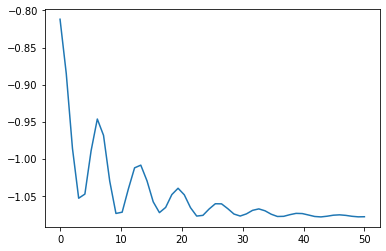

In [17]:
x = np.linspace(0, numPoints, numPoints)
plt.plot(x, energies)
plt.show()

In [18]:
print(C)

[0.09420978 0.16749818 0.1130246  0.02398223 0.09420978 0.16749818
 0.1130246  0.02398223]


#### Now, the nuclear motion from 9.3.2

Now some derivatives for the nuclear motion molecular dynamics. Again, those could be optimized by passing overlap and so on. For example a lot of things are computed here and also re-computed in the calls of the functions inside. 
Also the computation would benefit from using symmetries to avoid computing many of the electron-electron integrals and also their derivative (it offers a roughly 8x speed improvement from this).
I'm not going to bother, this is done in the C++ Hartree-Fock project, check that out for the details.

In [19]:
# 9.39
def F0Deriv(t):
    if t == 0:
        return -1./3.
    return (m.exp(-t) - F0(t))/(2. * t)

In [20]:
# 9.34
def OverlapTwoCentersDeriv(alpha, beta, Ra, Rb, X):
    difR = Ra - Rb
    X2 = difR.dot(difR)
    if X2 == 0:
        return 0        
    return -2. * alpha * beta / (alpha + beta) * X * OverlapTwoCenters(alpha, beta, Ra, Rb)

In [21]:
# 9.36
def KineticTwoCentersDeriv(alpha, beta, Ra, Rb, X):
    difR = Ra - Rb
    len2 = difR.dot(difR)
    if len2 == 0:
        return 0
    aplusb = alpha + beta
    ab = alpha * beta / aplusb # sigma in the book
    ab2 = ab * ab
    return -4. * ab2 * X * OverlapTwoCenters(alpha, beta, Ra, Rb) + (3 * ab - 2 * ab2 * X * X) * OverlapTwoCentersDeriv(alpha, beta, Ra, Rb, X)

In [22]:
# 9.40 and 9.41
def NuclearDeriv(alpha, beta, Ra, Rb, X, Z = 1.):
    aplusb = alpha + beta
    theta = 2. * m.sqrt(aplusb/m.pi)
    X2 = X * X
    
    difR = Ra - Rb
    len2 = difR.dot(difR)
    if len2 == 0:
        return -2. * Z * theta * OverlapTwoCenters(alpha, beta, Ra, Rb) * F0Deriv(aplusb * X2) * X * aplusb # 9.40

    alpha2 = alpha * alpha
    beta2 = beta * beta
    
    t1 = alpha2 * X2 / aplusb # 9.42a
    t2 = beta2 * X2 / aplusb  # 9.42b
    
    # 9.41
    return -Z * theta * (OverlapTwoCentersDeriv(alpha, beta, Ra, Rb, X) * (F0(t1) + F0(t2)) + 2. / aplusb * X * OverlapTwoCenters(alpha, beta, Ra, Rb) * (F0Deriv(t1) * alpha2 + F0Deriv(t2) * beta2))

In [23]:
# 9.47 - there is some renaming to have the same names as in TwoElectronTwoCenter
def TwoElectronTwoCenterDeriv(alpha, beta, gamma, delta, Ra, Rb, Rc, Rd, X):   
    RP = Rp(alpha, gamma, Ra, Rc) # 9.38
    RQ = Rp(beta, delta, Rb, Rd) # 9.45        
    alphaplusgamma = alpha + gamma
    betaplusdelta = beta + delta
    PQ = RP - RQ
    PQ2 = PQ.dot(PQ)
    cdiv = alphaplusgamma * betaplusdelta / (alphaplusgamma+betaplusdelta)

    t = cdiv * PQ2 # 9.44
    rho = 2. * m.sqrt(cdiv / m.pi) # 9.46
    F0t = F0(t)
        
    return rho * (
        (OverlapTwoCentersDeriv(alpha, gamma, Ra, Rc, X) * OverlapTwoCenters(beta, delta, Rb, Rd) + 
        OverlapTwoCenters(alpha, gamma, Ra, Rc) * OverlapTwoCentersDeriv(beta, delta, Rb, Rd, X)) * F0t +
        OverlapTwoCenters(alpha, gamma, Ra, Rc) * OverlapTwoCenters(beta, delta, Rb, Rd) * F0Deriv(t) * cdiv * 2 * PQ2 / X
    )

In [24]:
HDeriv = np.zeros((basisSize * 2, basisSize * 2))
ODeriv = np.zeros((basisSize * 2, basisSize * 2))
QDeriv = np.zeros((basisSize*2, basisSize*2, basisSize*2, basisSize*2))
QtDeriv = np.zeros((basisSize*2, basisSize*2, basisSize*2, basisSize*2))
FDeriv = np.zeros((2*basisSize, 2*basisSize))

Here is the interesting part:

In [25]:
X = 1.35
Xprev = X
R1 = np.array([X, 0, 0])

for i in range(basisSize):
    a = alpha[i]
    for j in range(basisSize):        
        b = alpha[j]
        O[i, j] = OverlapTwoCenters(a, b, R0, R0)
        O[i, 4 + j] = OverlapTwoCenters(a, b, R0, R1)
        O[4 + i, j] = O[i, 4 + j]
        O[4 + i, 4 + j] = O[i, j]  
            
# reinitialize Cs
v = 0
for i in range(2 * basisSize):
    for j in range(2 * basisSize):
        v += O[i, j]
v = 1. / m.sqrt(v)

C = np.array([v, v, v, v, v, v, v, v])
Cprev = C.copy()    

M = 1836.5 * mass

numPoints = 43

Nucleardt = numPoints * dt # 4.3 (atomic units)
Nucleardt2 = Nucleardt * Nucleardt

numNuclearPoints = 300
distances = np.zeros((numNuclearPoints))

# friction stuff for nuclei

Nucleargamma = 15. # set it to zero if you want no 'friction'

MassMinusGamma = M - 0.5 * Nucleargamma * Nucleardt
MassPlusGamma = M + 0.5 * Nucleargamma * Nucleardt

In [26]:
for nuclearCycle in range(numNuclearPoints):
       
    # recompute each time since the atoms positions change each nuclear cycle
        
    for i in range(basisSize):
        a = alpha[i]
        for j in range(basisSize):        
            b = alpha[j]
            O[i, j] = OverlapTwoCenters(a, b, R0, R0)
            O[i, 4 + j] = OverlapTwoCenters(a, b, R0, R1)
            O[4 + i, j] = O[i, 4 + j]
            O[4 + i, 4 + j] = O[i, j]  
        
            H[i, j] = KineticTwoCenters(a, b, R0, R0) + Nuclear(a, b, R0, R0, R0) + Nuclear(a, b, R0, R0, R1)
            H[i, 4 + j] = KineticTwoCenters(a, b, R0, R1) + Nuclear(a, b, R0, R1, R0) + Nuclear(a, b, R0, R1, R1)
            H[4 + i, j] =  H[i, 4 + j]
            H[4 + i, 4 + j] = H[i, j] 
            
            for k in range(basisSize):
                c = alpha[k]
                for l in range(basisSize):
                    d = alpha[l]                                    
                    Q[i, j, k, l]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R0, R0)
                    Q[i, j, k, basisSize+l]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R0, R1)
                    Q[i, j, basisSize+k, l]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R1, R0)
                    Q[i, j, basisSize+k, basisSize+l]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R1, R1)
                    Q[i, basisSize+j, k, l]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R0, R0)
                    Q[i, basisSize+j, k, basisSize+l]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R0, R1)
                    Q[i, basisSize+j, basisSize+k, l]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R1, R0)
                    Q[i, basisSize+j, basisSize+k, basisSize+l]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R1, R1)
                    Q[basisSize+i, j, k, l]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R0, R0)
                    Q[basisSize+i, j, k, basisSize+l]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R0, R1)
                    Q[basisSize+i, j, basisSize+k, l]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R1, R0)
                    Q[basisSize+i, j, basisSize+k, basisSize+l]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R1, R1)
                    Q[basisSize+i, basisSize+j, k, l]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R0, R0)
                    Q[basisSize+i, basisSize+j, k, basisSize+l]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R0, R1)
                    Q[basisSize+i, basisSize+j, basisSize+k, l]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R1, R0)
                    Q[basisSize+i, basisSize+j, basisSize+k, basisSize+l]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R1, R1)       
    
    
    for p in range(2*basisSize):
        for q in range(2*basisSize):
            for r in range(2*basisSize):
                for s in range(2*basisSize):
                    Qt[p, q, r, s] = 2. * Q[p, q, r, s] - Q[p, r, s, q]                    
                    
                 
    # compute derivatives, similar for the other ones, but with removed computations for the same center for overlap and h derivatives, for the values that are zero
    
    for i in range(basisSize):        
        a = alpha[i]
        for j in range(basisSize):        
            b = alpha[j]
            ODeriv[i, 4 + j] = OverlapTwoCentersDeriv(a, b, R0, R1, X)
            ODeriv[4 + i, j] = ODeriv[i, 4 + j]
            
            HDeriv[i, j] = NuclearDeriv(a, b, R0, R0, X)            
            HDeriv[i, 4 + j] = NuclearDeriv(a, b, R0, R1, X) + KineticTwoCentersDeriv(a, b, R0, R1, X)
            HDeriv[4 + i, j] = HDeriv[i, 4 + j]
            HDeriv[4 + i, 4 + j] = HDeriv[i, j] 
    
            for k in range(basisSize):
                c = alpha[k]
                for l in range(basisSize):
                    d = alpha[l]                                    
                    QDeriv[i, j, k, l]=TwoElectronTwoCenterDeriv(a, b, c, d, R0, R0, R0, R0, X)
                    QDeriv[i, j, k, basisSize+l]=TwoElectronTwoCenterDeriv(a, b, c, d, R0, R0, R0, R1, X)
                    QDeriv[i, j, basisSize+k, l]=TwoElectronTwoCenterDeriv(a, b, c, d, R0, R0, R1, R0, X)
                    QDeriv[i, j, basisSize+k, basisSize+l]=TwoElectronTwoCenterDeriv(a, b, c, d, R0, R0, R1, R1, X)
                    QDeriv[i, basisSize+j, k, l]=TwoElectronTwoCenterDeriv(a, b, c, d, R0, R1, R0, R0, X)
                    QDeriv[i, basisSize+j, k, basisSize+l]=TwoElectronTwoCenterDeriv(a, b, c, d, R0, R1, R0, R1, X)
                    QDeriv[i, basisSize+j, basisSize+k, l]=TwoElectronTwoCenterDeriv(a, b, c, d, R0, R1, R1, R0, X)
                    QDeriv[i, basisSize+j, basisSize+k, basisSize+l]=TwoElectronTwoCenterDeriv(a, b, c, d, R0, R1, R1, R1, X)
                    QDeriv[basisSize+i, j, k, l]=TwoElectronTwoCenterDeriv(a, b, c, d, R1, R0, R0, R0, X)
                    QDeriv[basisSize+i, j, k, basisSize+l]=TwoElectronTwoCenterDeriv(a, b, c, d, R1, R0, R0, R1, X)
                    QDeriv[basisSize+i, j, basisSize+k, l]=TwoElectronTwoCenterDeriv(a, b, c, d, R1, R0, R1, R0, X)
                    QDeriv[basisSize+i, j, basisSize+k, basisSize+l]=TwoElectronTwoCenterDeriv(a, b, c, d, R1, R0, R1, R1, X)
                    QDeriv[basisSize+i, basisSize+j, k, l]=TwoElectronTwoCenterDeriv(a, b, c, d, R1, R1, R0, R0, X)
                    QDeriv[basisSize+i, basisSize+j, k, basisSize+l]=TwoElectronTwoCenterDeriv(a, b, c, d, R1, R1, R0, R1, X)
                    QDeriv[basisSize+i, basisSize+j, basisSize+k, l]=TwoElectronTwoCenterDeriv(a, b, c, d, R1, R1, R1, R0, X)
                    QDeriv[basisSize+i, basisSize+j, basisSize+k, basisSize+l]=TwoElectronTwoCenterDeriv(a, b, c, d, R1, R1, R1, R1, X)       
     
    
    for p in range(2*basisSize):
        for q in range(2*basisSize):
            for r in range(2*basisSize):
                for s in range(2*basisSize):
                    QtDeriv[p, q, r, s] = 2. * QDeriv[p, q, r, s] - QDeriv[p, r, s, q]

                    
    # the electronic loop - it's identical with the one above that's done only for electronic part, with the energy computation moved out of it

    for cycle in range(numPoints):

        # Fock matrix computation
        for i in range(2*basisSize):
            for j in range(2*basisSize):
                F[i, j] = H[i, j]
                for k in range(2*basisSize):
                    for l in range(2*basisSize):
                        F[i, j] += Qt[i, k, j, l] * C[k] * C[l]
                
        # Verlet for electrons
                    
        # compute Ct - 9.31, but with friction force added
            
        Ct = (2. * mass * C - massMinusGamma * Cprev - 4. * F.dot(C) * dt2) / massPlusGamma
                
        # determine lambda - see 9.32 - but be careful, it's wrong! Get it from 9.28 by replacing C[r] = Ct[r] - lambda * h^2 * sum(S[r, s]*C[s]), h^4 and h^2 are missing (here h is dt)
     
        OC = O.dot(C)
        OCt = O.dot(Ct)
        OOC = O.dot(OC)
    
        a = OOC.dot(OC) * dt4
        b = -2. * OC.dot(OCt) * dt2
        c = OCt.dot(Ct) - 1.
        
        delta = b*b - 4.*a*c
        if delta < 0:
            print("Delta negative!")
            break
        
        sdelta = m.sqrt(delta)
        lam1 = (-b-sdelta) / (2. * a)
        lam2 = (-b+sdelta) / (2. * a)

        if lam1 < 0:
            lam = lam2
        else:
            lam = lam1
    
        # now adjust the newly computed Cs    
    
        Ct -= lam * dt2 * OC
        
        # switch to the next step
        Cprev = C
        C = Ct            
                        
        # end electronic loop
        

    # compute energy
    #Eg = C.dot(H + F).dot(C) + 1. / X
    #print(Eg)
                        
    # verlet for nuclear
                     
    for i in range(2*basisSize):
        for j in range(2*basisSize):
            FDeriv[i, j] = HDeriv[i, j]
            for k in range(2*basisSize):
                for l in range(2*basisSize):
                    FDeriv[i, j] += QtDeriv[i, k, j, l] * C[k] * C[l]
    
    lam *= massPlusGamma * 0.5 # correction - there is a 2 factor in the lambda, also needs to be adjusted because of the massPlusGamma division
                
    # C.dot(ODeriv).dot(C) can be reduced to a quarter, knowing that diagonal sectors are zero
    LambdaFactor = 0
    for i in range(basisSize):
        for j in range(basisSize):
            LambdaFactor += ODeriv[basisSize + i, j] * C[basisSize + i] * C[j]
            LambdaFactor += ODeriv[i, basisSize + j] * C[i] * C[basisSize + j]
        
    FNuclear = C.dot(HDeriv + FDeriv).dot(C) - 1. / (X * X) + lam * LambdaFactor
    
    Xnew = (2. * M * X - MassMinusGamma * Xprev - 2. * FNuclear * Nucleardt2) / MassPlusGamma
        
    # switch to the next step
    Xprev = X
    X = Xnew
    
    # also update the nuclei position
    R1 = np.array([X, 0, 0]) 
    
    distances[nuclearCycle] = X

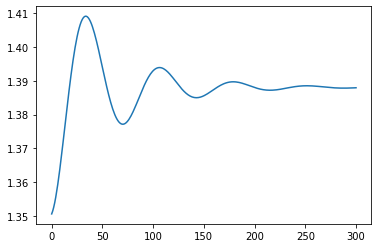

In [27]:
x = np.linspace(0, numNuclearPoints, numNuclearPoints)
plt.plot(x, distances)

In [28]:
print(X) # the experimental value given in the book is 1.401, the equilibrium with Hartree-Fock using only s-type orbitals is 1.3881

1.387958948624326
